In [26]:
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

# Setup
You need to have precomputed some files describing files locations in order for this notebook to run.

Take a look at notebook 1 in order to generate them.

In [ ]:
datasets = ['timit', 'wavefake', 'mozilla', 'ljspeech']

# Compute Metrics for audio files across all datasets

In [ ]:

# Function to calculate metrics for a single audio file
def get_audio_metrics(audio_file):
    # load
    y, sr = librosa.load(audio_file) 

    # metrics
    duration = librosa.get_duration(y=y, sr=sr)
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    energy_distribution = librosa.feature.chroma_stft(S=np.abs(librosa.stft(y)), sr=sr)
    zero_crossings_rate = librosa.feature.zero_crossing_rate(y)

    return {
        "Audio File": audio_file,
        "Duration": duration,
        "Centroid": np.mean(centroid),
        "Rolloff": np.mean(rolloff),
        "Bandwidth": np.mean(bandwidth),
        "Energy Distribution": np.mean(energy_distribution),
        "Zero Crossings Rate": np.mean(zero_crossings_rate),
    }

In [ ]:
datasets_dfs = []

# for each dataset
# compute metrics and store into a dataframe
# afterwards append to the list above
for dataset in datasets:
    d_file = f'{dataset}_data_files_summary.csv'
    audio_files = pd.read_csv(d_file).sample(n=100)['full_path'].to_list()
    # Initialize an empty list to store dictionaries of metrics
    results_list = []

    # Calculate metrics for each audio file in parallel and add them to the list
    results_list = Parallel(n_jobs=8)(delayed(get_audio_metrics)(audio_file) for audio_file in audio_files)

    # Create a Pandas DataFrame from the list
    dataset_results_df = pd.DataFrame(results_list)
    dataset_results_df['dataset'] = dataset
    dataset_results_df.to_csv(f'description/{dataset}_results.csv')
    datasets_dfs.append(dataset_results_df)

# concatenate all results
results_df = pd.concat(datasets_dfs)
results_df.head()

# Dataset Properties

In [ ]:
results_df_g = results_df.groupby(['dataset']).agg(total_duration=('duration', sum),
                                                   n_samples=('duration', 'count'),
                                                   mean_duration=('duration', 'mean'),
                                                   min_duration=('duration', 'min'),
                                                   max_duration=('duration', 'max')
                                                   )
results_df_g

# Metrics Histograms across Datasets

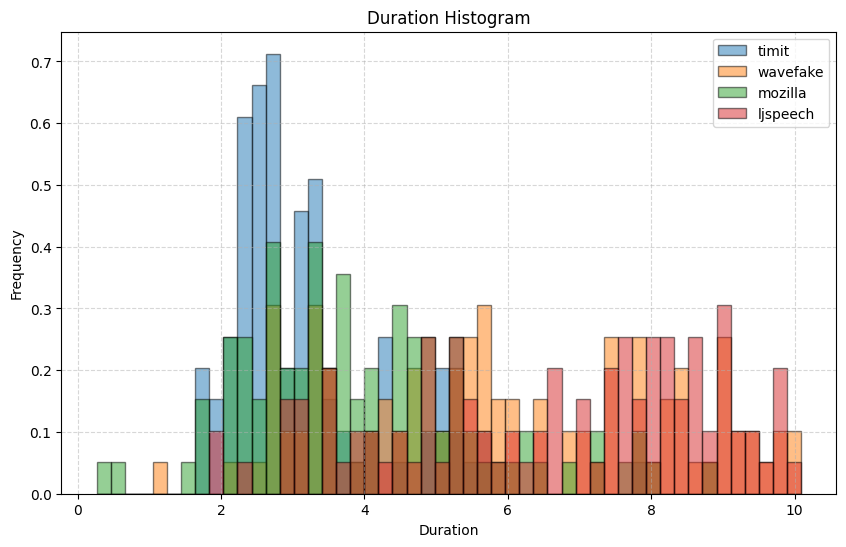

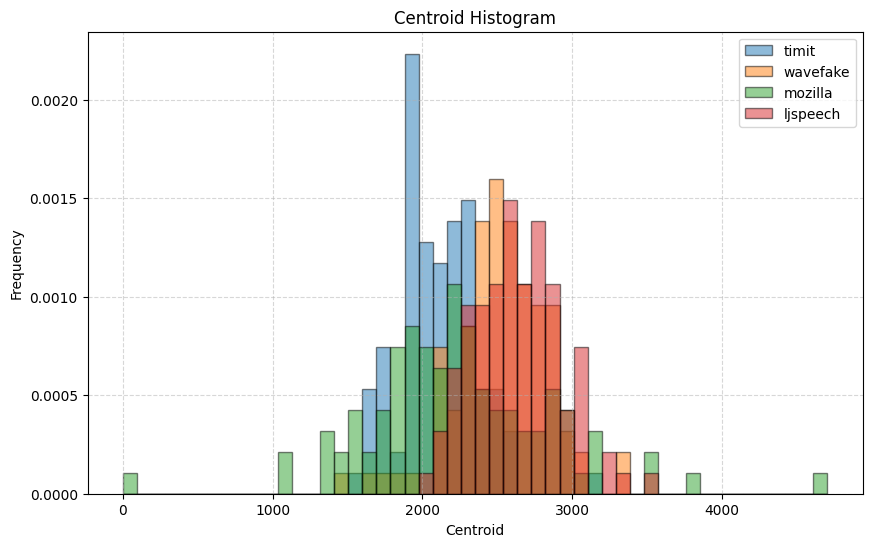

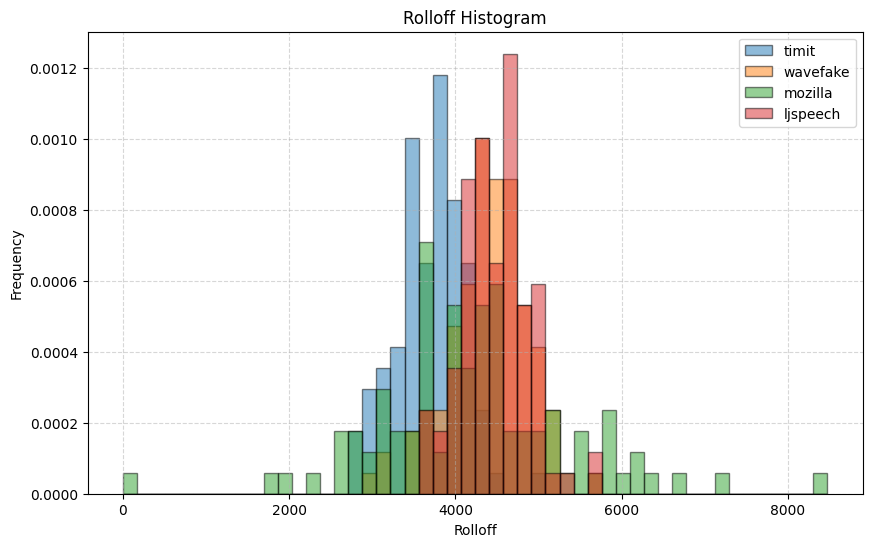

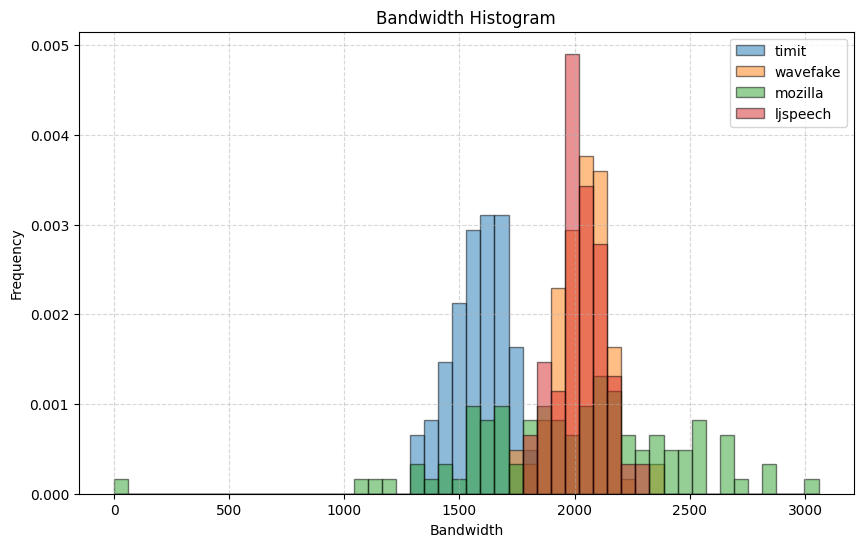

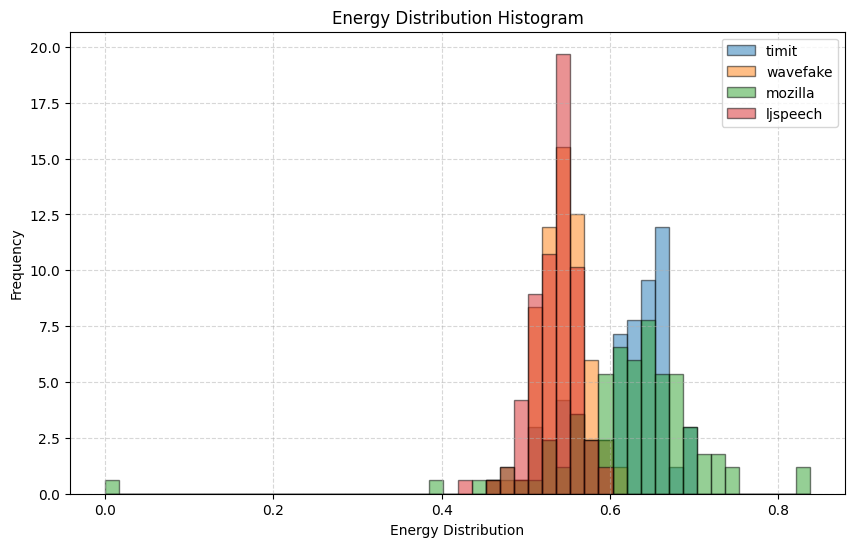

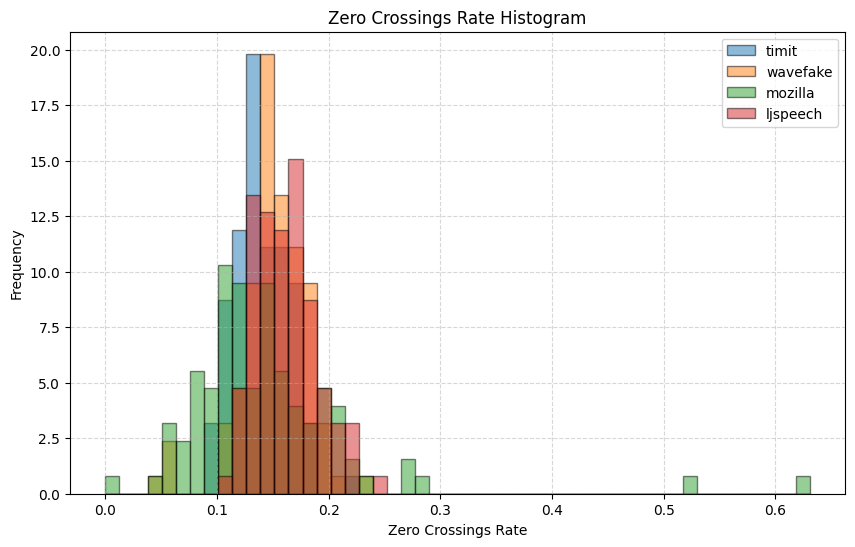

In [25]:
for metric_name in results_df.columns:
    # skip invalid columns
    if metric_name in ['Audio File', 'dataset']:
        continue
    
    num_bins = 50
    max_v = results_df[metric_name].max()
    min_v = results_df[metric_name].min()
    bin_positions = [min_v + (i * (max_v-min_v) / num_bins) for i in range(num_bins + 1)]
    plt.figure(figsize=(10, 6)) 
    for d in results_df['dataset'].unique():
        values = results_df.loc[results_df['dataset']==d, metric_name]   
        plt.hist(values,  bins=bin_positions, edgecolor='black', alpha=0.5, label=d, density=True)
    
    plt.title(f"{metric_name} Histogram")
    plt.xlabel(metric_name)
    plt.ylabel("Frequency")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.show()